In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce GTX 1650


device(type='cuda')

In [2]:
# import torchvision.datasets

# CelebA_dataset = torchvision.datasets.CelebA(root='.', download=True)

In [3]:
# %%time

import h5py
# import zipfile
# import imageio
# import os

# hdf5_file = 'celeba/celeba_aligned_small.h5py'

# total_images = 20000

# with h5py.File(hdf5_file, 'w') as hf:
#     count = 0
#     with zipfile.ZipFile('celeba/img_align_celeba.zip', 'r') as zf:
#         for i in zf.namelist():
#             if (i[-4:] == '.jpg'):
#                 ofile = zf.extract(i)
#                 img = imageio.imread(ofile)
#                 os.remove(ofile)
#                 hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
#                 count = count + 1
#                 if (count%1000 == 0):
#                     print("images done .. ", count)
#                     pass
#                 if (count == total_images):
#                     break
#                 pass
#             pass
#         pass

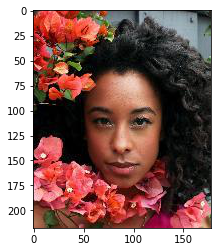

In [4]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(np.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    pass

celeba_dataset = CelebADataset('celeba/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

In [5]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

In [7]:
%%time

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: total: 44min 38s
Wall time: 5min 36s


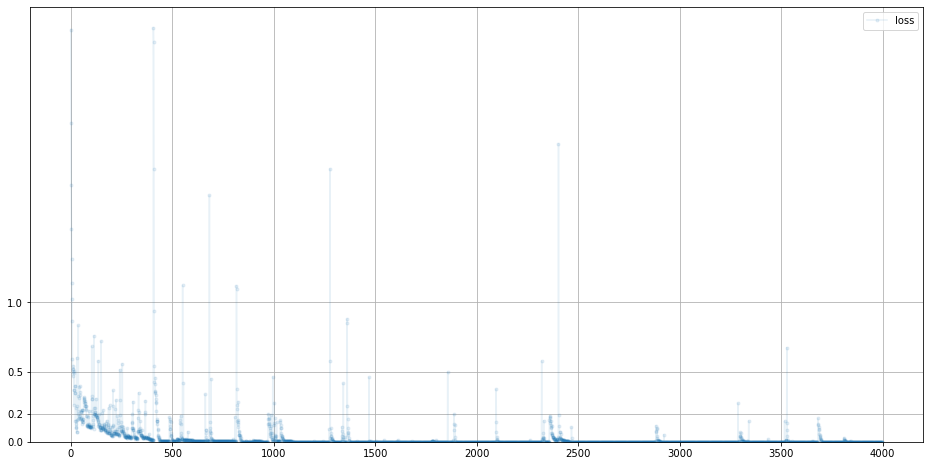

In [8]:
D.plot_progress()

In [9]:
for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0,20000)]
    print(D.forward(image_data_tensor).item())
    pass

for i in range(4):
    print(D.forward(generate_random_image((218,178,3))).item())
    pass

0.9998544454574585
0.9996950626373291
0.9998681545257568
0.999850869178772
7.018911128398031e-05
7.295166869880632e-05
7.384673517663032e-05
7.148824806790799e-05


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218, 178, 3))
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

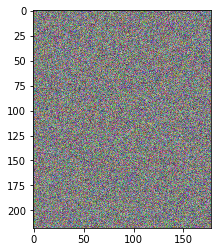

In [11]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation = 'none', cmap = 'Blues')

In [12]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: total: 1h 56min 5s
Wall time: 14min 32s


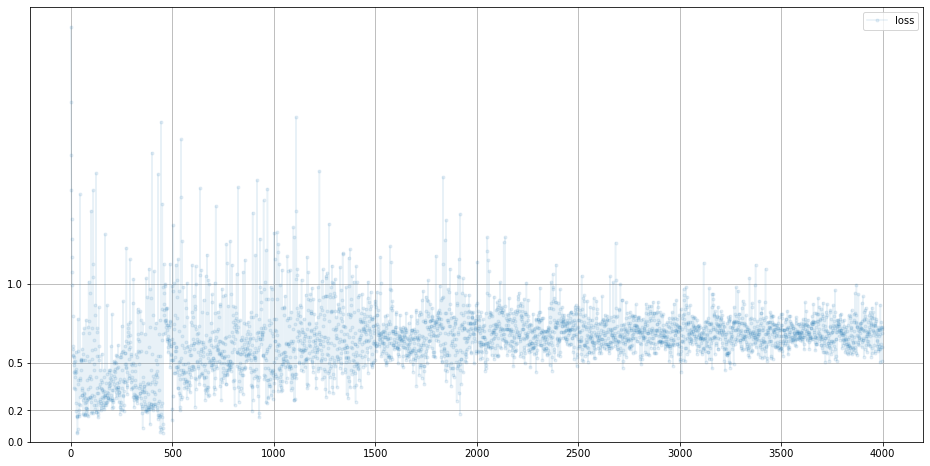

In [13]:
D.plot_progress()

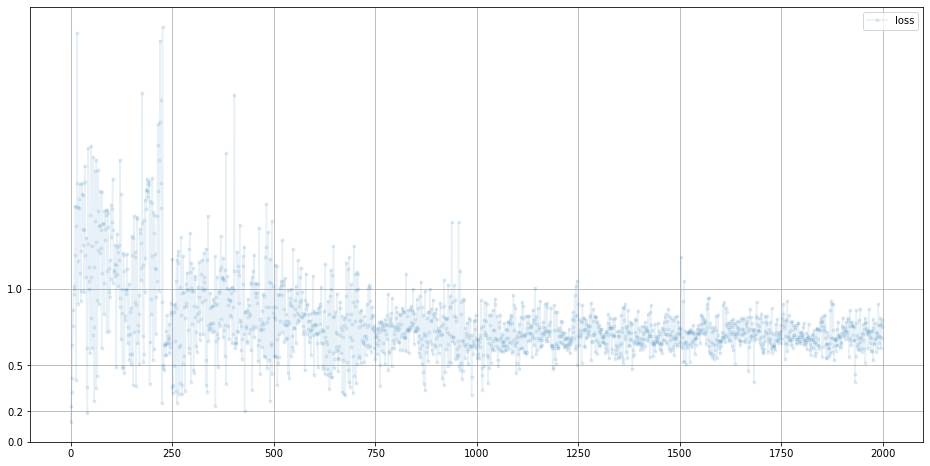

In [14]:
G.plot_progress()

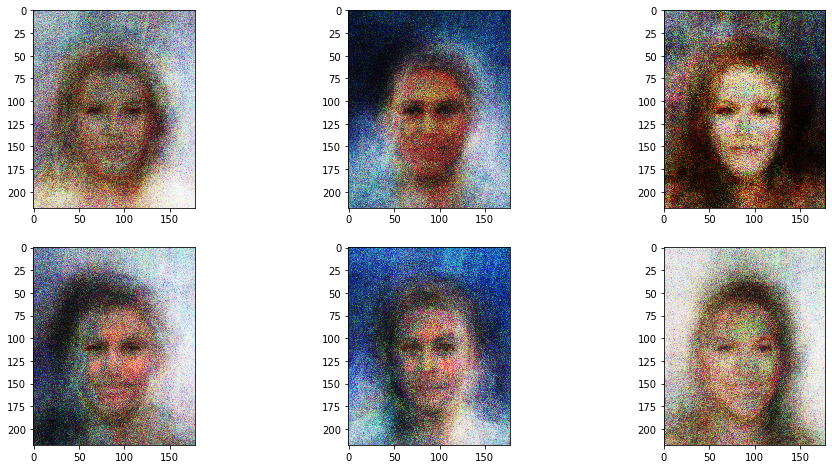

In [15]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
        pass
    pass

In [16]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.6999950408935547

In [17]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.0935635566711426

In [18]:
print(torch.cuda.memory_summary(device, abbreviated = True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  733998 KB |    1119 MB |   19252 GB |   19252 GB |
|---------------------------------------------------------------------------|
| Active memory         |  733998 KB |    1119 MB |   19252 GB |   19252 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1220 MB |    1220 MB |    1220 MB |       0 B  |
|---------------------------------------------------------------